# **COMP9727 Recommender Systems**
## Assignment: Content-Based Movie Recommendation

@Author: Pyae Sone OO (z5271704)


## Setting Up

For the first part of the assignment, the set up steps are based on the code from tutorial

#### Initialising the directory for dataset

Before you run the code, please double the check the directory. Initially, the dataset folder is in the same directory as this file.

In [1]:
dataset_dir = "dataset/"

#### Loading Data

We will load the dataset and convert it into a data frame.

In [2]:
import pandas as pd

# Define the genre labels and file paths
genre_labels = ["animation", "comedy", "drama", "family", "horror", "romance", "sci-fi", "thriller"]
# NOTE: You can modify directory for the dataset here
genre_files = [f"{dataset_dir}{genre}.tsv" for genre in genre_labels] 

genre_dict = {}

# Check if each genre file exists and read it
for file_path, genre in zip(genre_files, genre_labels):
    try:
        df = pd.read_csv(file_path, sep='\t')
        df.columns = ["Title", "Year", "Genre", "Director", "Cast", "Plot", "Country"]
        # Create 'Document' column by linking relevant fields
        df['Document'] = df.apply(lambda row: f"{row['Title']} {row['Year']} {row['Genre']} {row['Director']} {row['Cast']} {row['Plot']} {row['Country']}", axis=1)
        genre_dict[genre] = df
    except Exception as e:
        print(f"An error occurred while reading {file_path}: {e}")

# Combine all movie data into a single DataFrame
if genre_dict:
    all_movies = pd.concat(genre_dict.values(), ignore_index=True)
else:
    print("ERROR: Empty Genre Dictionary. Try again.")

#### Data Cleansing 

We will remove the duplicates and missing values in our dataset.

In [3]:
all_movies = all_movies.drop_duplicates();
all_movies = all_movies.dropna()

#### Preparation for Machine Learning
We will define two varaibles X and y, to reduce reptitive  and long varaible name call.

In [4]:
# X: Feature data (preprocessed documents)
# y: Labels (genres)
X = all_movies['Document']
y = all_movies['Genre']

## Part 1: Topic (Genre) Classification

### Q1 (2 marks) 
There are a few simplifications in the Jupyter notebook in the tutorial: (i) the regex might remove too many special characters, and (ii) the evaluation is based on only one training test split rather than using cross-validation. Explain how you are going to fix these mistakes and then highlight any changes to the code in the answers to the next questions.

[Ans] <br>

Firstly, the code from the tutorial was removing too many special characters. To preserve potential data from the provided movie dataset, we must consider some special characters that a movie title could contain. Hence, we will modify the code to allow alphanumeric numbers, whitespaces, and punctuation marks such as periods, commas, exclamation points, and question marks. The code will look as follows: ``` text = re.sub(r'[^\w\s.,!?]', '', text)```

Secondly, cross-validation is preferred over a single training-test split because it allows more reliable model performance by evaluating the model on multiple subsets of the data. Hence, it reduces the impact of random variations and improves generalization to new data. For the cross-validation method, StratifiedKfold would be used due to the nature of the dataset where the target variable is a genre and there is imbalanced distribution of genres. This method would ensure each fold is representative of the overall dataset.


### Q2 (2 marks) 
Develop a Multinomial Naive Bayes (MNB) model similar to the Bernoulli Naive Bayes (BNB) model. Now consider all the steps in text preprocessing used prior to classification with both BNB and MNB. The aim here is to find preprocessing steps that maximize overall accuracy (under the default settings of the classifiers and using CountVectorizer with the standard settings). Consider the special characters to be removed (and how and when they are removed), the definition of a “word”, the stopword list (from either NLTK or scikit-learn), lowercasing andstemming/lemmatization. Summarize the preprocessing steps that you think work “best” overall and do not change this for the rest of the assignment.

[Ans] <br>
First of all, we are going to preprocess the text data because raw text data contains unwanted character, punctuations and stopwords which makes it unstructured and noisy so it is important to clean and organise the text data before feeding it into the model. In this process, we are going to implement the redefined Regex expression that was mentioned in the previous question.

<u>Note</u>: In the preprocessing function, some of the steps are commented out to yield the higheest accuracy score which are used in the later questions.

In [5]:
# Import necessary modules
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Download stopwords and punkt tokenizer
nltk.download('stopwords')
nltk.download('punkt')

# Create Instances
ps = PorterStemmer()
pl = WordNetLemmatizer()

# Create a set of English stopwords
stop_words = set(stopwords.words('english'))

# Define preprocessing function
# 1. Lowecasing     - converts to lower case letters
# 2. Regex          - Ignoring alphanumeric numbers, whitespaces, and punctuations [. , ! ?]
# 3. Tokenising     - tokenize the text in preparation for next steps
# 4. Stowords       - Removing common words
# 5. Stemming       - Reducing words to their root form (e.g., "running" to "run")
# 6. Lemmatizing    - Reducing words to their dictionary form (e.g., "better" to "good")
# NOTE: some of the steps are commented out to produce highest accuracy score
def preprocess_text(text):
    text = text.lower()
    # text = re.sub(r'[^\w\s.,!?]', '', text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    # tokens = [ps.stem(word) for word in tokens]
    tokens = [pl.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

# Apply preprocessing to each document
X = X.apply(preprocess_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\z5271\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\z5271\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


As mentioned in the question, we will be using "**CountVectorizer**" in the creation of models. In the code below, we will use pipeline which will make it easier to streamline the process of transforming the data and fitting the model. Once the models are created, they will be evaluated using cross-validation instead of train-testsplit because the change in evalutaion method should yield higher and more reliable scores by leveraging the entire dataset more effectively.

In [6]:
## Model Evaluation

# Import necessary modules
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB , BernoulliNB
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score

#-- Part.1-2: Using CountVectorizer
vectorizer = CountVectorizer()

# Define the cross-validation method: StratifiedKfold [explaination in Part1.q1]
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create and evaluate Bernoulli Naive Bayes model
bnb = BernoulliNB()
pipeline_bnb = make_pipeline(vectorizer, bnb)
cv_scores_bnb = cross_val_score(pipeline_bnb, X, y, cv=kf, scoring='accuracy')
print("Accuracy Score (BNB) => ", cv_scores_bnb.mean())


# Create and evaluate Multinomial Naive Bayes model
mnb = MultinomialNB();
pipeline_mnb = make_pipeline(vectorizer, mnb)
cv_scores_mnb = cross_val_score(pipeline_mnb, X, y, cv=kf, scoring='accuracy')
print("Accuracy Score (MNB) => ", cv_scores_mnb.mean())

Accuracy Score (BNB) =>  0.6512953367875648
Accuracy Score (MNB) =>  0.6243523316062176


Now, we will record the scores by using different combination of preprocessing techniques to see which method would produce higher scores. Following is the table of accuracy scores using **cross validation** and **CountVectorizer** for both Bernoulli Naive Bayes Model (BNB) and Multinomial Naive Bayes Model (MNB):

| LowerCasing | Regex | Stopwords | Stemming | Lemmatizing | BNB score   | MNB score   |
|-------------|-------|-----------|----------|-------------|-------------|-------------|
| -           | -     | -         | -        | -           | 0.626943005 | 0.625388601 |
| ✔           | ✔     | ✔         | ✔        | -           | 0.639896373 | 0.619170984 |
| -           | ✔     | ✔         | ✔        | -           | 0.633678756 | 0.617616580 |
| ✔           | -     | ✔         | ✔        | -           | 0.650259067 | 0.623316062 |
| ✔           | ✔     | -         | ✔        | -           | 0.617098446 | 0.622279793 |
| ✔           | -     | -         | ✔        | -           | 0.630051813 | **0.628497409** |
| -           | ✔     | -         | ✔        | -           | 0.616580311 | 0.622279793 |
| -           | -     | ✔         | ✔        | -           | 0.644559585 | 0.619689119 |
| -           | -     | -         | ✔        | -           | 0.629015544 | 0.628497409 |
| ✔           | ✔     | ✔         | -        | ✔           | 0.633678756 | 0.626943005 |
| -           | ✔     | ✔         | -        | ✔           | 0.625907636 | 0.624870466 |
|  ✔         | -     | ✔         | -        | ✔           | **0.651295337** | 0.624352332 |
| ✔           | ✔     | -         | -        | ✔           | 0.61865285  | 0.619689119 |
| ✔           | -     | -         | -        | ✔           | 0.623834197 | 0.624870466 |
| -           | ✔     | -         | -        | ✔           | 0.612953368 | 0.624352332 |
| -           | -     | ✔         | -        | ✔           | 0.64559855  | 0.622279793 |
| -           | -     | -         | -        | ✔           | 0.62277927  | 0.620725389 |






As shown in the table, for Bernoulii Naive Bayes Model (BNB),the highest score is 0.651295337 (~ 65.13%) using lowercasing, removal of stopwords and lemmatizing in the preprocessing step. On the other side, for Multinomial Bayes Model, the highest score is 0.628497409 (~ 62.85%) using lowercasing and stemming in the preprocessing step. By comparing the highest scores from both model, I decided to use Lowercasing, removal of stopwards and lemmatizing for assignment.

### Q3 (2 marks)

Compare BNB and MNB models by evaluating them using the full dataset with cross-validation. Choose appropriate metrics from those in the lecture that focus on the overall accuracy of classification (i.e. not top-N metrics). Briefly discuss the tradeoffs between the various
metrics and then justify your choice of the main metrics for evaluation, taking into account whether this dataset is balanced or imbalanced. On this basis, conclude whether either of BNB or MNB is superior. Justify this conclusion with plots/tables.


[Ans] <br>
Given this balanced nature of the dataset, the evaluation metrics such as accuracy, precision, recall, and F1-score can all be reliably used to assess model performance as there is no risk of skewed metrics due to class imbalance, making accuracy a valid metric for comparison alongside precision, recall, and F1-score.

Various Metrics:
* **Overall Accuracy**: Ensures that genres are classified properly, providing an overall accurate score. It represents the ratio of true positives and true negatives to the entire dataset.

* **Precision**: Measures the number of true positives classified out of all data classified as positive. It indicates the number of movies correctly classified in the right genre.

* **Recall**: Measures the number of true positives classified out of all actual positives. It shows how well the model captures movies that belong to the genre.

* **F1-Score**: A balanced measure of precision and recall. It helps to understand the model's performance in terms of both correctly classifying true positives and minimizing false positives and false negatives.

In the code below, we will define a function to evaluate the Bernoulli and Multinomial Naive Bayes models using cross-validation on various metrics.Then The results will be compiled into a DataFrame for comparison.

In [7]:
# Function to evaluate the models using cross-validation on various metrics
def evaluate_model(pipeline, X, y, cv):
    accuracy = cross_val_score(pipeline, X, y, cv=cv, scoring='accuracy').mean()
    precision = cross_val_score(pipeline, X, y, cv=cv, scoring='precision_macro').mean()
    recall = cross_val_score(pipeline, X, y, cv=cv, scoring='recall_macro').mean()
    f1 = cross_val_score(pipeline, X, y, cv=cv, scoring='f1_macro').mean()
    return accuracy, precision, recall, f1

# Evaluate the models
bnb_scores = evaluate_model(pipeline_bnb, X, y, kf)
mnb_scores = evaluate_model(pipeline_mnb, X, y, kf)

# Create a DataFrame for comparison
scores_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'BNB': bnb_scores,
    'MNB': mnb_scores
})

# Display the data frame of the scores
print(scores_df)

      Metric       BNB       MNB
0   Accuracy  0.651295  0.624352
1  Precision  0.717376  0.628860
2     Recall  0.648062  0.623651
3   F1-Score  0.652077  0.619306


Now we will plot the the scores data frame to compare the two models.

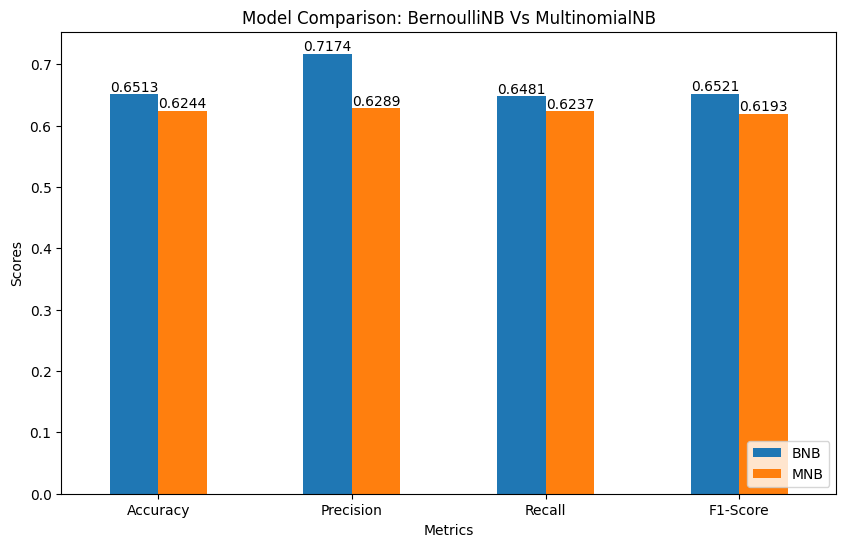

In [8]:

import matplotlib.pyplot as plt

# Plot the comparison
plot_axes = scores_df.set_index('Metric').plot(kind='bar', figsize=(10, 6))
plot_axes.set_title('Model Comparison: BernoulliNB Vs MultinomialNB')
plot_axes.set_xlabel('Metrics')
plot_axes.set_ylabel('Scores')

# Add bar labels to each container in the plot, 
# formatting the data values to 4 decimal places,
# and positioning the labels at the edge of each bar
for container in plot_axes.containers:
    labels = [f'{x:.4f}' for x in container.datavalues]
    plot_axes.bar_label(container, labels=labels, label_type='edge')

    
plot_axes.set_xticklabels(plot_axes.get_xticklabels(), rotation=0)
plot_axes.legend(loc='lower right')
plt.show()


From the above bar chart, we can see that:
* **Accuracy**: BNB (0.6513) is superior to MNB (0.6244).
* **Precision**: BNB (0.7174) is significantly higher than MNB (0.6289).
* **Recall**: BNB (0.6481) is higher than MNB (0.6237).
* **F1-Score**: BNB (0.6521) outperforms MNB (0.6193).

Therfore, Bernoulli Naive Bayes (BNB) is concluded to be the superior model for this balanced dataset, based on higher scores across all metrics.​

### Q4 (2 marks)
Consider varying the number of features (words) used by BNB and MNB in the classification, using the sklearn setting which limits the number to the top N most frequent words in the Vectorizer. Compare classification results for various values for N and justify, based on experimental results, one value for N that works well overall and use this value for the rest of the assignment. Show plots or tables that support your decision. The emphasis is on clear presentation of the results so do not print out large tables or too many tables that are difficult to understand.


[Ans] <br>
We will first evaluate the pefromance of BNB and MNB classifiers by different number of features(N) used by CountVectorizer, which limits the vocabulary to the top N most frequent words. For each value of features, we create pipelines and then use cross-validation to predict the labels and calculate the accuracy scores for the models. Then, we will collect and store the results in a DataFrame. The code is as follow:

In [9]:
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import accuracy_score

# Values for N (number of features)
n_values = [500, 1000, 2000, 5000, 10000]

# Define the cross-validation method
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Function to evaluate the models
# 1. Initialize CountVectorizer with a maximum number of features.
# 2. Create BernoulliNB and MultinomialNB models.
# 3. Create pipelines combining the vectorizer and the models.
# 4. Use cross-validation to predict the labels for both models.
# 5. Calculate the accuracy for both models.
# 6. Return the accuracy scores.
def evaluate_model_with_n_features(n_features, X, y, cv):
    vectorizer = CountVectorizer(stop_words='english', max_features=n_features)
    
    bnb = BernoulliNB()
    mnb = MultinomialNB()
    pipeline_bnb = make_pipeline(vectorizer, bnb)
    pipeline_mnb = make_pipeline(vectorizer, mnb)
    
    y_pred_bnb = cross_val_predict(pipeline_bnb, X, y, cv=cv)
    y_pred_mnb = cross_val_predict(pipeline_mnb, X, y, cv=cv)
    
    bnb_accuracy = accuracy_score(y, y_pred_bnb)
    mnb_accuracy = accuracy_score(y, y_pred_mnb)
    
    return bnb_accuracy, mnb_accuracy

# Collect results for different values of N
results = {'Num of Features': [], 'BernoulliNB': [], 'MultinomialNB': []}
for n in n_values:
    bnb_accuracy, mnb_accuracy = evaluate_model_with_n_features(n, X, y, cv)
    
    # Store data in adjacent fields
    results['Num of Features'].append(n)
    results['BernoulliNB'].append(bnb_accuracy)
    results['MultinomialNB'].append(mnb_accuracy)

# Convert results to DataFrame
results_df = pd.DataFrame(results)

Again, we will be plotting the results data frame to compare the results visually.

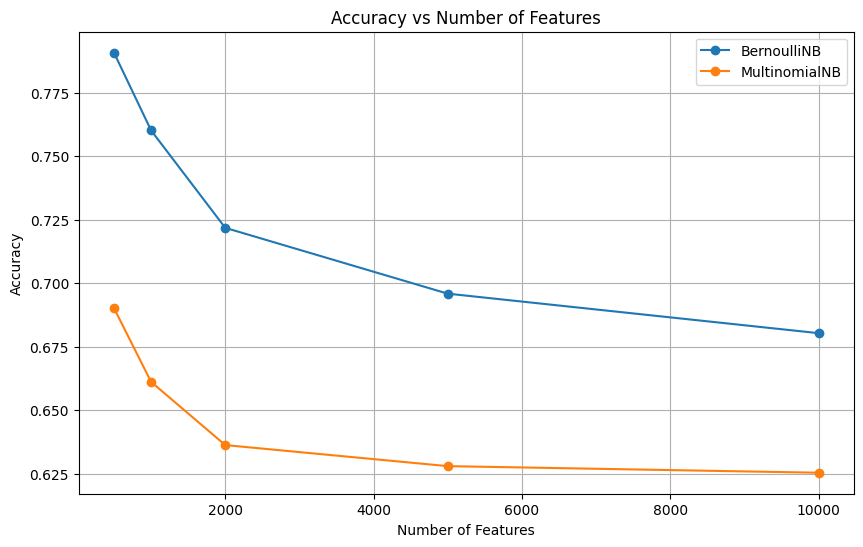

   Num of Features  BernoulliNB  MultinomialNB
0              500     0.790674       0.690155
1             1000     0.760104       0.661140
2             2000     0.721762       0.636269
3             5000     0.695855       0.627979
4            10000     0.680311       0.625389


In [10]:
# Plot results
plt.figure(figsize=(10, 6))
plt.plot(results_df['Num of Features'], results_df['BernoulliNB'], marker='o', label='BernoulliNB')
plt.plot(results_df['Num of Features'], results_df['MultinomialNB'], marker='o', label='MultinomialNB')
plt.title('Accuracy vs Number of Features')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Prints the data frame to compare the scores
print(results_df)


From the results, we can see that using fewer number of features results in better accuracy, With 500 features, BernoulliNB achieves highest score of 0.790674 (~ 79.07%) and MultinomialNB achieves the highest score of  0.690155 (~  69.02%). Hence, BernoulliNB with 500 features have the best overall performance in classifying movie genres so this configuration will be used for the rest of the assignment.

### Q5 (5 marks)
Choose one other machine learning method, perhaps one mentioned in the lecture.
Summarize this method in a single tutorial-style paragraph and explain why you think it is suitable for topic classification for this dataset (for example, maybe other people have used this method for a similar problem). Use the implementation of this method from a standard machine learning library such as sklearn (not other people’s code from the Internet) to implement this method on the news dataset using the same text preprocessing as for BNB and MNB. If the method has any hyperparameters for tuning, explain how you will select those settings (or use the default settings), and present a concrete hypothesis for how this method will compare to BNB and MNB.

[Ans] <br>
From the lecture, I decided to go with Random Forest. The method builds multiple decision trees and combine their results to generate more accurate and reliable predictions. 

**Hypothesis**: <br>
The results for RandomForestClassifier is exepected perform better than BNB and MNB but since it is done with deafault settings, the performance might not be fully optimized.

**Implementation**: <br>
 We will evalutate the performance of BNB, MNB and RandomForest Classifer by different number of features used by CountVectorizer. Then, the accuracy of each model is calculated using cross-validation and results will be collected in a dataframe. For this implementation, RandomForestClassifier is used with deafault settings.

In [11]:
# Import necessary module
from sklearn.ensemble import RandomForestClassifier

# Define the cross-validation method
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Function to evaluate a given model with a given number of features
def evaluate_model_with_n_features(model, n_features, X, y, cv):
    vectorizer = CountVectorizer(max_features=n_features)
    pipeline = make_pipeline(vectorizer, model)
    
    accuracy_scores = cross_val_score(pipeline, X, y, cv=cv, scoring='accuracy')
    accuracy = accuracy_scores.mean()

    return accuracy

# Values for N (number of features)
n_values = [500, 1000, 2000, 5000, 10000]

# Initialize models
bnb = BernoulliNB()
mnb = MultinomialNB()
rf = RandomForestClassifier(random_state=42)

# Collect results for different values of N
results = {
    'Number of Features': [],
    'MultinomialNB Accuracy': [],
    'BernoulliNB Accuracy': [],
    'RandomForest Accuracy': [],
}

for n in n_values:
    # Evaluate BernoulliNB, MultinomialNB, Random Forest
    bnb_accuracy = evaluate_model_with_n_features(bnb, n, X, y, kf)
    mnb_accuracy = evaluate_model_with_n_features(mnb, n, X, y, kf)
    rf_accuracy = evaluate_model_with_n_features(rf, n, X, y, kf)
    
    results['Number of Features'].append(n)
    results['MultinomialNB Accuracy'].append(mnb_accuracy)
    results['BernoulliNB Accuracy'].append(bnb_accuracy)
    results['RandomForest Accuracy'].append(rf_accuracy)


### Q5 (Continued) 
Conduct experiments (and show the code for these experiments) using cross-validation and  comment on whether you confirmed (or not) your hypothesis. Finally, compare this method to BNB and MNB on the metrics you used in Step 3 and choose one overall “best” method and settings for topic classification.

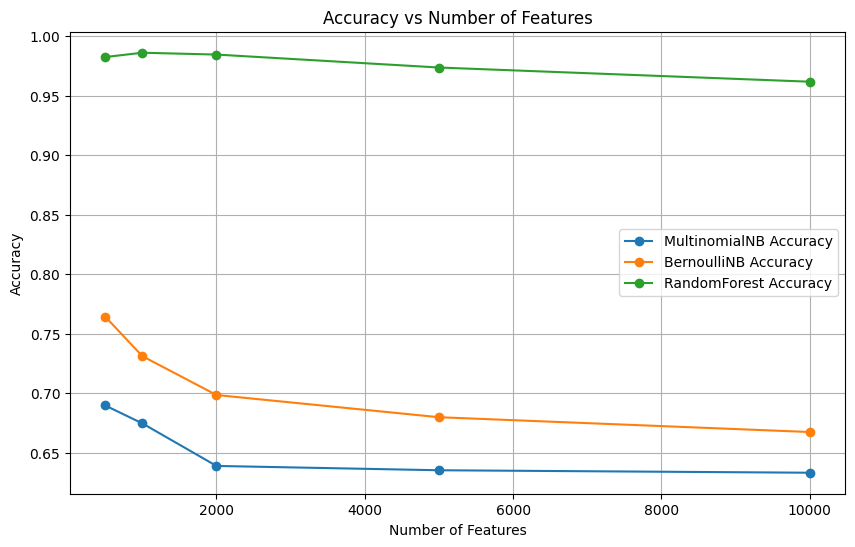

   Number of Features  MultinomialNB Accuracy  BernoulliNB Accuracy  \
0                 500                0.689637              0.764249   
1                1000                0.674611              0.731088   
2                2000                0.638860              0.698446   
3                5000                0.635233              0.679793   
4               10000                0.633161              0.667358   

   RandomForest Accuracy  
0               0.982383  
1               0.986010  
2               0.984456  
3               0.973575  
4               0.961658  


In [12]:
# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Plot results
plt.figure(figsize=(10, 6))
for model in ['MultinomialNB Accuracy', 'BernoulliNB Accuracy', 'RandomForest Accuracy']:
    plt.plot(results_df['Number of Features'], results_df[model], marker='o', label=model)
    
plt.title('Accuracy vs Number of Features')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Display the results DataFrame
print(results_df)

Based on the graph and output of the dataframe, the RandomForestClassifier consistently outperformed both BNB and MNB across all values of features. Hence, this proves my hypothesis.

Although BNB and MNB has the highest accuracy using 500 features, RandomForestClassifer provides the highes accuracy at 1000 features. Thus, RandomForestClaasifer will be chosen as the best method with the setting of 1000 features for topic classification.

## Part 2

### Q1 (6 marks)
 Consider the information retrieval algorithms for “matching” user profiles to “documents” described in the lecture. The basic idea is that the classifier will be used to assign a movie to one of the 8 classes, and the user profile will consist of the words, or top M words, in a set of movies of interest to that user for each of the 8 classes, which can then be converted into a vector (term frequency, tf-idf, etc.) for each of the 8 categories. CountVectorizer or TfidfVectorizer can be used for the conversion.

Suppose a user sees N recommended movies articles in a sitting, and “likes” some of them. Choose and justify appropriate metrics to evaluate the performance of the recommendation method. Also choose an appropriate value for N based on how you think the movies will be presented. Pay attention to the large variety of movies and the need to obtain useful feedback from the user.

Unfortunately we do not have any real users for our system (because it has not yet been built!), but we want some idea of how well it would perform. We will invent two hypothetical users, and simulate their usage of the system. We specify the interests of each user with a set of keywords for each genre. These user profiles can be found in the files `user1.tsv` and `user2.tsv` where each line in the file is a genre and (followed by a tab) a list of keywords. All the words are case insensitive. For the purpose of this exercise, we consider that the users are not interested in any other movies. **Important: Although we know the pairing of the genres and keywords, all the recommender system “knows” is what movies the user liked in each genre.**

We now need to consider how we would get training data for the user profiles in practice. There are 250 movies in each file. Suppose that the order in the file is the time ordering of the movies, and for concreteness, suppose these movies came from a series of weeks, so that the Week 1 movies are 1–50, Week 2 are 51–100, Week 3 are 101–150 and Week 4 are 151–200 (and ignore the others).

Develop user profiles for User 1 and User 2 from the simulated training data (not the keywords used to define their interests) by supposing they liked all the movies from Weeks 1–3 that matched their interests including being predicted to be in the right category (i.e. assume the true genre is not known and the topic classifier is used to predict the movie genre). Print the top 20 words in their profiles for each of their topics of interest. Comment if these words seem reasonable.

[Ans]<br>
Firstly, we are going to to do some imports and inital setup by setting the dataset. Secondly, We will preprocess the the data with the chosen combination from part 1 which is Lowercasing, Removal of Stopwords ( which are from NLTK library) and Lemmatizing. Afterwards, the dataset will be split into two sections with first 150 being the training set and next 50 for the testing set of data. Then we will vectorize the documents using the chosen setting of ```max_features`` as 1000 and train our classifers using default settings.

In [13]:
## Importing Necessary Moduels (again just in case!)
from collections import defaultdict
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

In [14]:
## Loading and initialising the dataset

# Define the genre labels and file paths
genre_labels = ["animation", "comedy", "drama", "family", "horror", "romance", "sci-fi", "thriller"]
# NOTE: You can modify directory for the dataset here
genre_files = [f"{dataset_dir}/{genre}.tsv" for genre in genre_labels] 

genre_dict = {}

# Check if each genre file exists and read it
for file_path, genre in zip(genre_files, genre_labels):
    try:
        df = pd.read_csv(file_path, sep='\t')
        df.columns = ["Title", "Year", "Genre", "Director", "Cast", "Plot", "Country"]
        # Create 'Document' column by linking relevant fields
        df['Document'] = df.apply(lambda row: f"{row['Title']} {row['Year']} {row['Genre']} {row['Director']} {row['Cast']} {row['Plot']} {row['Country']}", axis=1)
        genre_dict[genre] = df
    except Exception as e:
        print(f"An error occurred while reading {file_path}: {e}")

In [15]:
##  Preprocessing the data

nltk.download('stopwords')
nltk.download('punkt')

stop_words = set(stopwords.words('english'))
pl = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [pl.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

for genre, df in genre_dict.items():
    df['Document'] = df['Document'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\z5271\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\z5271\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [16]:
## Splitting the dataset

# 0 to 150 => training set of data (used for user profiles)
# 150 to 200 => testing set of data (probably used for recommendations)
training_set = pd.concat([df.iloc[:150] for df in genre_dict.values()])
testing_set = pd.concat([df.iloc[150:200] for df in genre_dict.values()])

In [17]:
## Vectoriziong the documents

# Keeping max_features = 1000 ( chosen setting from Part 1) 
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
train_tfidf = tfidf_vectorizer.fit_transform(training_set['Document'])
test_tfidf = tfidf_vectorizer.transform(testing_set['Document'])

In [18]:
## Training the classifer

# Using RandomForest method as it was chosen from Part 1
# We are using default settings
classifier = RandomForestClassifier(random_state=42)
classifier.fit(train_tfidf, training_set['Genre'])

# Predict genres for these movies
training_set['Predicted_Genre'] = classifier.predict(tfidf_vectorizer.transform(training_set['Document']))

Now that we have data setup, we are now going to start with the user side of things. As mentioned in the question, using the provided user1.tsv and user2.tsv, we will fruther develop their profiles based on our trianing set and user's intial data, then average TF-IDF vectors of the movies they like.A Afterwards, we willl extract top 20 words in each genre from each user's profiles and output them.

In [19]:
## Loading user 1 and 2
# NOTE: set your directory to user data here
# Initially the directory is set as empty because the datafile is in same directory as this file.
user_data_dir = ""

user1 = pd.read_csv(f"{user_data_dir}user1.tsv", sep='\t', header=None, names=['Genre', 'Words'])
user2 = pd.read_csv(f"{user_data_dir}user2.tsv", sep='\t', header=None, names=['Genre', 'Words'])

In [20]:
## Create Profles for each users

# Function to develop user profiles based on data of training set
def develop_profiles(user_data, training_set):
    updated_profile = defaultdict(lambda: np.zeros(tfidf_vectorizer.max_features))

    # Ensure user_profile is initialized for all genres in user data
    for index, row in user_data.iterrows():
        genre = row['Genre']
        if genre not in updated_profile:
            updated_profile[genre] = np.zeros(tfidf_vectorizer.max_features)

        # Update the profile with user's initial profile data
        user_words = row['Words'].split()
        for word in user_words:
            if word in tfidf_vectorizer.vocabulary_:
                word_index = tfidf_vectorizer.vocabulary_[word]
                updated_profile[genre][word_index] += 1
    
    # Update the profile for each genre based on liked movies
    for genre in user_data['Genre'].unique():
        genre_movies = training_set[training_set['Predicted_Genre'] == genre]
        
        if not genre_movies.empty:
            genre_vectors = tfidf_vectorizer.transform(genre_movies['Document']).toarray()
            updated_profile[genre] += np.mean(genre_vectors, axis=0)
        else:
            print(f"No movies found for genre: {genre}")
    
    # Normalize user profile vectors
    for genre in updated_profile:
        norm = np.linalg.norm(updated_profile[genre])
        if norm > 0:
            updated_profile[genre] = updated_profile[genre] / norm
    
    return updated_profile

# Create the user profiles
user1_profile = develop_profiles(user1, training_set)
user2_profile = develop_profiles(user2, training_set)

In [21]:
## Extract Top 20 words and output them

# Function to extract top 20 words for each genre (PART-2.q1: N=20)
def get_top_words(user_profile):
    feature_names = tfidf_vectorizer.get_feature_names_out()
    top_words_list = []
    N = 20;

    for genre, vector in user_profile.items():
        top_indices = vector.argsort()[-N:][::-1]
        top_words = [feature_names[i] for i in top_indices]
        top_words_list.append({'Genre': genre, 'Word-list': top_words})
    
    return top_words_list

# Function to print the top words of each users
def print_top_words(user_top_words):
    for entry in user_top_words:
        genre = entry['Genre']
        words = entry['Word-list']
        print(f"Genre: {genre}, Top Words: {', '.join(words)}")
    

# Fetch and output the top words of each genre for each user 
user1_tw = get_top_words(user1_profile)
user2_tw = get_top_words(user2_profile)

print("User(1)'s top words:")
print_top_words(user1_tw)

print("\nUser(2)'s top words:")
print_top_words(user2_tw)

User(1)'s top words:
Genre: animation, Top Words: princess, dragon, dog, cat, animation, find, king, friend, animal, back, city, return, life, escape, help, try, one, named, father, new
Genre: comedy, Top Words: chase, comedy, chinese, wang, get, li, friend, go, love, chen, amy, yang, one, zhang, find, 2015, 2016, 2017, life, year
Genre: drama, Top Words: family, wedding, drama, 2017, school, chinese, 2016, life, father, two, mother, japanese, year, screenplay, high, one, student, new, story, friend
Genre: family, Top Words: family, father, dog, harry, find, mother, school, get, tell, go, child, take, home, back, friend, return, boy, one, mr, life
Genre: horror, Top Words: vampire, ghost, video, footage, horror, house, find, kill, group, zombie, body, death, paul, later, night, room, family, killed, child, human
Genre: romance, Top Words: girlfriend, dance, boyfriend, romance, love, relationship, school, life, father, year, time, kong, friend, chinese, li, one, mother, go, hong, woman


From observation, the words from each genre seem reasonable and well aligned with the genre. For example, the words such as princess, dragon, dog and cat , fits with the category "animation". This indicates the profiles generated reflect the expected content of the movies within each genre.

### Q1(continued)
Define another hypothetical “user” (User 3) by choosing different keywords across a range of genres (perhaps those that match your interests or those of someone you know), and print the top 20 keywords in their profile for each of their topics of interest. Comment if these words seem reasonable.

[Ans]<br>
Now we are going define user 3 with with different keywords. First, we are going to convert the user3 into a dataframe but unlike user 1 and 2, we have to develop the user profile based on the defined keywords and create the profile. Then, same as previous step, we will extract top 20 words and then output them.

In [22]:
# Define User 3 with predefined words
user3 = {
    'animation': 'funny adventure family',
    'comedy': 'funny humor laugh',
    'drama': 'serious emotional relationship',
    'horror': 'scary ghost thriller',
}

# Function to develop user profiles based keywords
def usr3_develop_profiles(user_data, training_set):
    updated_profile = defaultdict(lambda: np.zeros(tfidf_vectorizer.max_features))

    # Ensure user_profile is initialized for all genres in user data
    for index, row in user_data.iterrows():
        genre = row['Genre']
        if genre not in updated_profile:
            updated_profile[genre] = np.zeros(tfidf_vectorizer.max_features)

        # Update the profile with user's initial profile data
        user_words = row['Words'].split()
        for word in user_words:
            if word in tfidf_vectorizer.vocabulary_:
                word_index = tfidf_vectorizer.vocabulary_[word]
                updated_profile[genre][word_index] += 1
    
    # Update the profile for each genre based on liked movies
    for genre in training_set['Genre'].unique():
        genre_movies = training_set[training_set['Predicted_Genre'] == genre]
        
        if not genre_movies.empty:
            genre_vectors = tfidf_vectorizer.transform(genre_movies['Document']).toarray()
            updated_profile[genre] += np.mean(genre_vectors, axis=0)
        else:
            print(f"No movies found for genre: {genre}")
    
    # Normalize user profile vectors
    for genre in updated_profile:
        norm = np.linalg.norm(updated_profile[genre])
        if norm > 0:
            updated_profile[genre] = updated_profile[genre] / norm
    
    return updated_profile

# Convert User 3 data to DataFrame
user3_df = pd.DataFrame(list(user3.items()), columns=['Genre', 'Words'])
user3_profile = usr3_develop_profiles(user3_df, training_set)

# Fetch and output the top words of each genre for User 3
user3_tw = get_top_words(user3_profile)
print("\nUser 3's top words:")
print_top_words(user3_tw)



User 3's top words:
Genre: animation, Top Words: family, animation, find, king, friend, animal, back, city, return, life, escape, help, try, one, named, father, new, take, world, bear
Genre: comedy, Top Words: comedy, chinese, wang, get, li, friend, go, love, chen, amy, yang, one, zhang, find, 2015, 2016, 2017, life, year, time
Genre: drama, Top Words: relationship, drama, 2017, school, chinese, 2016, life, father, two, mother, japanese, year, screenplay, high, one, student, new, family, story, friend
Genre: horror, Top Words: ghost, thriller, horror, house, find, kill, group, zombie, body, death, vampire, paul, later, night, room, family, killed, child, human, student
Genre: family, Top Words: family, father, dog, harry, find, mother, school, get, tell, go, child, take, home, back, friend, return, boy, one, mr, life
Genre: romance, Top Words: romance, love, relationship, school, life, father, year, time, kong, friend, chinese, li, one, mother, go, hong, woman, meet, lin, girl
Genre: 

From observation, although most words are fitting with the relative genres, there are repetitive words that appear in some genre. For example, the word "friend" appearing in animation, drama family , comedy and romance categories. The recurring words is logical becasuse there weren't any keywords provided for all genres so the profile creation process has the capable of providing logical insight despite the missing data.

#### Q2 (6 marks)
Suppose a user sees N recommended movies and “likes” some of them. Choose and justify appropriate metrics to evaluate the performance of the recommendation method. Also choose an appropriate value for N based on how you think the movies will be presented. Pay attention to the large variety of movies and the need to obtain useful feedback from the user (i.e. they must like some movies shown to them).

Evaluate the performance of the recommendation method by testing how well the top N movies that the recommender suggests for Week 4, based on the user profiles, match the interests of each user. That is, assume that each user likes all and only those movies in the top N recommendations that matched their profile for the predicted (not true) genre (where N is your chosen value). State clearly whether you are showing N movies in total or N movies per genre. As part of the analysis, consider various values for M, the number of words in the user profile for each genre, compared to using all words.

Show the metrics for some of the matching algorithms to see which performs better for Users 1, 2 and 3. Explain any differences between the users. On the basis of these results, choose one algorithm for matching user profiles and movies and explain your decision.

[Ans]<br>
In this question, we are firsly going to combine vectors in user profile into one single vector then we will use the vectors to match the top 10 recommendations. I am choosing the number ten because it is good amount of number that a user would be willing to read the list where the amount is not too much or too little. Then, the top 20 recommended movies will be outputed.

For getting the top recommendations, we will be using **cosine_similary** form ```sklearn.metrics.pairwise``` libarary. This tool's function is to measure how two vectors are similar which would be applicable when we compare vectors of user profile and testing data set.

In [23]:
## Get top 20 recommendation for each user

# Import necessary module
from sklearn.metrics.pairwise import cosine_similarity

# Function to combine user profile vectors into a single vector
# Have eight genres => combined into a vector
def combine_user_profile(user_profile):
    combined_vector = np.zeros(tfidf_vectorizer.max_features)
    for vector in user_profile.values():
        combined_vector += vector
    norm = np.linalg.norm(combined_vector)
    if norm > 0:
        combined_vector = combined_vector / norm
    return combined_vector

# Function to get top N recommendations for a combined user profile
def get_top_recommendations(user_profile, test_tfidf):
    # top N movies that recommander suggestes for Week 4
    top_n = 10 
    
    combined_profile = combine_user_profile(user_profile)
    similarities = cosine_similarity(combined_profile.reshape(1, -1), test_tfidf).flatten()
    top_indices = similarities.argsort()[-top_n:][::-1]
    return top_indices

# Function to print the top recommendations
def print_recommendations(top_indices, test_set):
    for i, idx in enumerate(top_indices, start=1):
            movie = test_set.iloc[idx]
            print(f"{i}. {movie['Title']}, Genre: {movie['Genre']}, Year: {movie['Year']}")

Now, we are going to do some calculate and evaluate the metric scores of each user profiles.

As done in previous part, we are going to be working with precision, f1 and recall scores. Precision score will indicate whether the the model makes correct prediciton and on the flip side, recall shows whether the model is missing a large number of relevant instances. F1 relects the balance between the two scores.

For the value of M, I am choosing 500 words for number of words in each genre in a user profile.

In [24]:
## Calculation and Evaluation of Metric Scores for each users

# Number of M ( number of words in each genre in user profile)
TOP_M = 500

# Generate recommendations based on top N words for each profile
def generate_recommendations(user_profile, top_n=TOP_M):
    feature_names = tfidf_vectorizer.get_feature_names_out()
    recommendations = defaultdict(list)
    
    for genre, vector in user_profile.items():
        top_indices = vector.argsort()[-top_n:][::-1]
        top_words = [feature_names[i] for i in top_indices]
        recommendations[genre] = top_words
    
    return recommendations

# Evaluate recommendations for each profile
def evaluate_recommendations(profile_recommendations, testing_set, top_n=TOP_M):
    precision_scores = []
    recall_scores = []
    f1_scores = []

    # Loop through each genre in the recommendations,
    # and compute precision, recall, and F1 scores by comparing
    # recommended words to actual words in the testing set
    for genre, recommended_words in profile_recommendations.items():
        genre_documents = testing_set[testing_set['Genre'] == genre]['Document']
        actual_words = set()
        
        for doc in genre_documents:
            actual_words.update(word_tokenize(doc))
        
        recommended_words_set = set(recommended_words[:top_n])

        true_positives = len(recommended_words_set & actual_words)
        false_positives = len(recommended_words_set - actual_words)
        false_negatives = len(actual_words - recommended_words_set)

        precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
        recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)

    return {
        'precision': np.mean(precision_scores),
        'recall': np.mean(recall_scores),
        'f1_score': np.mean(f1_scores)
    }

# Generate recommendations for each user
user1_recommendations = generate_recommendations(user1_profile)
user2_recommendations = generate_recommendations(user2_profile)
user3_recommendations = generate_recommendations(user3_profile)

# Evaluate recommendations for each user
user1_metrics = evaluate_recommendations(user1_recommendations, testing_set)
user2_metrics = evaluate_recommendations(user2_recommendations, testing_set)
user3_metrics = evaluate_recommendations(user3_recommendations, testing_set)


# Output the evaluation metrics of each users
print("User 1's metrics:")
print(user1_metrics)

print("\nUser 2's metrics:")
print(user2_metrics)

print("\nUser 3's metrics:")
print(user3_metrics)

User 1's metrics:
{'precision': 0.9259999999999999, 'recall': 0.10385025931863848, 'f1_score': 0.18657112890512667}

User 2's metrics:
{'precision': 0.9313333333333333, 'recall': 0.09788534227205133, 'f1_score': 0.17714678744516377}

User 3's metrics:
{'precision': 0.9257500000000001, 'recall': 0.10382348125522803, 'f1_score': 0.1865227542921236}


Now that we have the scores, we are going to plot them.

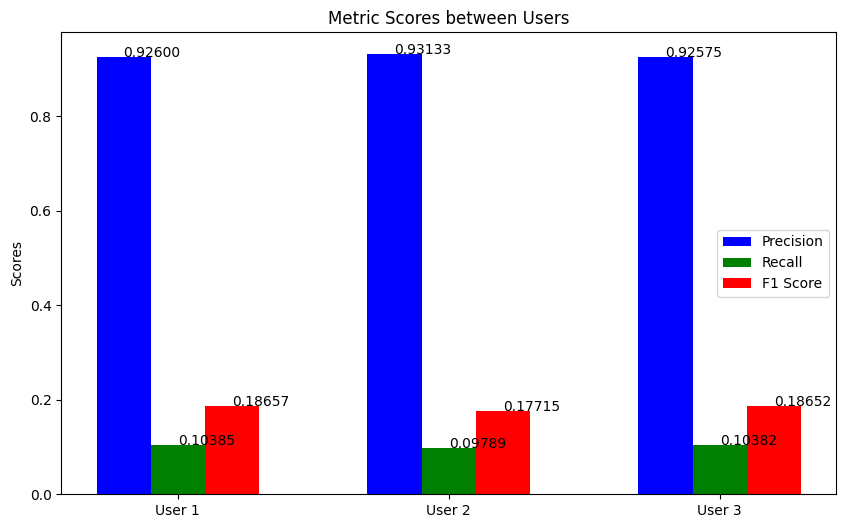

In [25]:
## Plotting the metric scores for three users

# Combine the metrics for all users into a single dictionary for easy plotting
user_metrics = {
    'User 1': user1_metrics,
    'User 2': user2_metrics,
    'User 3': user3_metrics
}

def plot_comparative_metrics(user_metrics):
    metrics = ['precision', 'recall', 'f1_score']
    users = list(user_metrics.keys())
    scores = {metric: [user_metrics[user][metric] for user in users] for metric in metrics}

    x = np.arange(len(users))  
    width = 0.2

    fig, ax = plt.subplots(figsize=(10, 6))
    
    bars_precision = ax.bar(x - width, scores['precision'], width, label='Precision', color='blue')
    bars_recall = ax.bar(x, scores['recall'], width, label='Recall', color='green')
    bars_f1 = ax.bar(x + width, scores['f1_score'], width, label='F1 Score', color='red')

    ax.set_ylabel('Scores')
    ax.set_title('Metric Scores between Users')
    ax.set_xticks(x)
    ax.set_xticklabels(users)
    ax.legend()

    # Showing the value of each bar
    for bars in [bars_precision, bars_recall, bars_f1]:
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.5f}', xy=(bar.get_x() + bar.get_width() / 2, height))

    plt.show()

plot_comparative_metrics(user_metrics)

From observation, The precision scores are high overall across all three users. However, recall and f1 struggles overall. On theoery, the recommendation system would be more efficient if it is trained over the keywords but my result doesn't agree with the staement.